### TP Nº3
Alumna: Lara Rosenberg

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.

En este caso, vamos a utilizar un modelo many to many donde las unidades van a ser palabras a traves de redes recurrentes.

In [1]:
# Importamos las librerias necesarias
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

import urllib.request
import bs4 as bs

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.utils import pad_sequences

import re

In [3]:
from nltk.corpus import gutenberg
import nltk
nltk.download('gutenberg')
import nltk
nltk.download('punkt')
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
!pip install -q gradio

### Datos
Tomaré como dataset el libro Emma, de Jane Austen. Tuve que descargarlo desde gutenberg porque textos info tenía roto el link

In [4]:
book = gutenberg.sents('austen-emma.txt')

# Preprocesamos el texto
sents = [' '.join(sentence) for sentence in book]
sents = [i.lower() for i in sents]
sents = [i.replace('[','') for i in sents]
sents = [i.replace(']','') for i in sents]
sents = [i.replace('-','') for i in sents]
sents = [i.replace(';','') for i in sents]
sents = [i.replace('_','') for i in sents]

df = pd.DataFrame(sents, columns=['Lines'])
print("Cantidad de documentos:", df.shape[0])
df.head()

Cantidad de documentos: 7752


,Lines
0,emma by jane austen 1816
1,volume i
2,chapter i
3,"emma woodhouse , handsome , clever , and rich ..."
4,she was the youngest of the two daughters of a...


In [5]:
# Eliminamos las filas que quedaron sin información en el dataset
df = df[df.Lines !=''].reset_index(drop=True)
df.shape[0]

7746

In [6]:
# Vemos las primeras oraciones
text = list(df.iloc[:,0])
text[0:10]

[' emma by jane austen 1816 ',
 'volume i',
 'chapter i',
 'emma woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence  and had lived nearly twenty  one years in the world with very little to distress or vex her .',
 "she was the youngest of the two daughters of a most affectionate , indulgent father  and had , in consequence of her sister ' s marriage , been mistress of his house from a very early period .",
 'her mother had died too long ago for her to have more than an indistinct remembrance of her caresses  and her place had been supplied by an excellent woman as governess , who had fallen little short of a mother in affection .',
 "sixteen years had miss taylor been in mr . woodhouse ' s family , less as a governess than a friend , very fond of both daughters , but particularly of emma .",
 'between them it was more the intimacy of sisters .',
 "even before miss taylor had ceased to hold t

Como utilizar todo el libro se volvió muy pesado para la memoria a la hora de realizar predicciones, decidí mantener únicamente la mitad de las filas del dataset (reducir el libro a la mitad)

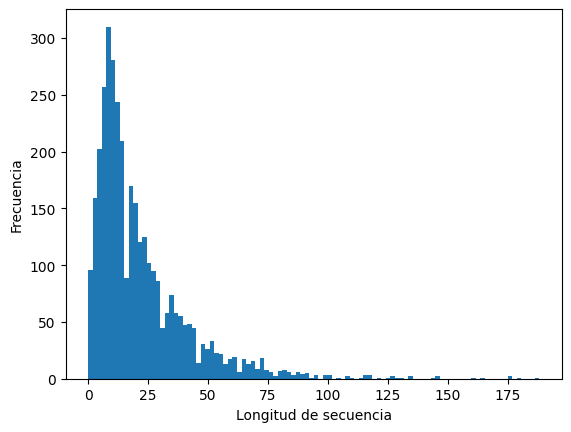

In [7]:
# segmentamos el texto
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text[0:3500]]

# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

# graficamos el histograma del tamaño de las oraciones
plt.hist(length_sentences, bins=100)
plt.xlabel('Longitud de secuencia')
plt.ylabel('Frecuencia')
plt.show()

In [8]:
# observamos si hay alguna que haya quedado con longitud 0
min(length_sentences)

0

In [10]:
# Eliminamos las oraciones cuyo tamaño es cero
segmented_sentences = [sentence for sentence in segmented_sentences if len(sentence) > 0]
len(segmented_sentences)

3497

In [11]:
# para determinar el tamaño máximo del contexto, tomé el percentil 70. La idea original era tomar el 90, pero daba un valor muy alto.
max_context_size = int(np.percentile(length_sentences, 70)-1) # el -1 es porque el último token será el target
print(f'max_context_size: {max_context_size}')

max_context_size: 24


Tokenizamos --> convierte las palabras en numeros

In [12]:
tok = Tokenizer()
tok.fit_on_texts(segmented_sentences)
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [13]:
# Observamos la primera oracion tokenizada
tokenized_sentences[0]

[33, 47, 120, 2917, 2918]

In [14]:
# La compramos con el texto: aca se puede ver que la palabra emma se está asignando al numero 33, by al numero 47 y asi sucesivamente
text[0]

' emma by jane austen 1816 '

Nos quedamos con un conjunto de datos de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad. Aca es importante resaltar que se tuvo que disminuir la proporción de validación ya que se quedaba sin memoria.

In [15]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.10, random_state=42)

In [16]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo, armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [17]:
tokenized_sentences_train[0]

[1, 1114, 48, 14, 1166, 519, 8, 1150, 209, 3, 1, 937, 8, 31, 14, 161, 1, 126]

In [18]:
tok_sent[0]

[1, 1114, 48, 14, 1166, 519, 8, 1150, 209, 3, 1, 937, 8, 31, 14, 161, 1, 126]

Ahora aumentamos los datos aprovechando que de una secuencia grande se pueden generar varias más pequeñas

In [19]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+3] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [20]:
# concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [21]:
train_seqs.shape

(519408, 25)

Estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]
Target: secuencia de tokens [$x_1$, $x_2$, ...,$x_{N+1}$]

In [22]:
# Calculamos las entradas y salidas del modelo
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

In [23]:
X[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          1, 1114], dtype=int32)

In [24]:
y[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    1,
       1114,   48], dtype=int32)

In [25]:
y.shape

(519408, 24)

In [26]:
# Palabras del vocabulario
tok.index_word

{1: 'the',
 2: 'to',
 3: 'and',
 4: 'of',
 5: 'a',
 6: 'i',
 7: 'her',
 8: 'it',
 9: 'was',
 10: 'she',
 11: 'in',
 12: 'not',
 13: 'he',
 14: 'be',
 15: 'that',
 16: 'you',
 17: 'had',
 18: 'as',
 19: 'but',
 20: 'for',
 21: 'very',
 22: 'mr',
 23: 'his',
 24: 'is',
 25: 'have',
 26: 'with',
 27: "'",
 28: 'so',
 29: 'at',
 30: 's',
 31: 'could',
 32: 'him',
 33: 'emma',
 34: 'all',
 35: 'would',
 36: 'been',
 37: 'no',
 38: 'any',
 39: 'my',
 40: 'on',
 41: 'do',
 42: 'miss',
 43: 'there',
 44: 'they',
 45: 'were',
 46: 'or',
 47: 'by',
 48: 'must',
 49: 'which',
 50: 'from',
 51: 'what',
 52: 'mrs',
 53: 'harriet',
 54: 'will',
 55: 'much',
 56: 'if',
 57: 'an',
 58: 'such',
 59: 'this',
 60: 'me',
 61: 'one',
 62: 'more',
 63: 'well',
 64: 'every',
 65: 'them',
 66: 'think',
 67: 'are',
 68: 'thing',
 69: 'good',
 70: 'said',
 71: 'being',
 72: 'than',
 73: 'little',
 74: 'should',
 75: 'weston',
 76: 'their',
 77: 'elton',
 78: 'only',
 79: 'never',
 80: 'knightley',
 81: 'we',
 8

In [27]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

5085

In [28]:
# El índice para cada palabra (el sistema las ordena de las más populares a las menos populares)
print(tok.word_index)

{'the': 1, 'to': 2, 'and': 3, 'of': 4, 'a': 5, 'i': 6, 'her': 7, 'it': 8, 'was': 9, 'she': 10, 'in': 11, 'not': 12, 'he': 13, 'be': 14, 'that': 15, 'you': 16, 'had': 17, 'as': 18, 'but': 19, 'for': 20, 'very': 21, 'mr': 22, 'his': 23, 'is': 24, 'have': 25, 'with': 26, "'": 27, 'so': 28, 'at': 29, 's': 30, 'could': 31, 'him': 32, 'emma': 33, 'all': 34, 'would': 35, 'been': 36, 'no': 37, 'any': 38, 'my': 39, 'on': 40, 'do': 41, 'miss': 42, 'there': 43, 'they': 44, 'were': 45, 'or': 46, 'by': 47, 'must': 48, 'which': 49, 'from': 50, 'what': 51, 'mrs': 52, 'harriet': 53, 'will': 54, 'much': 55, 'if': 56, 'an': 57, 'such': 58, 'this': 59, 'me': 60, 'one': 61, 'more': 62, 'well': 63, 'every': 64, 'them': 65, 'think': 66, 'are': 67, 'thing': 68, 'good': 69, 'said': 70, 'being': 71, 'than': 72, 'little': 73, 'should': 74, 'weston': 75, 'their': 76, 'elton': 77, 'only': 78, 'never': 79, 'knightley': 80, 'we': 81, 'own': 82, 'man': 83, 'am': 84, 'know': 85, 'your': 86, 'did': 87, 'might': 88, 'h

In [29]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
print(tok.word_docs)

defaultdict(<class 'int'>, {'1816': 1, 'jane': 88, 'austen': 1, 'emma': 368, 'by': 231, 'volume': 2, 'i': 892, 'chapter': 27, 'best': 41, 'comfortable': 23, 'home': 61, 'vex': 1, 'unite': 1, 'world': 37, 'with': 485, 'of': 1320, 'little': 175, 'twenty': 20, 'in': 778, 'very': 555, 'lived': 17, 'the': 1362, 'one': 189, 'woodhouse': 133, 'seemed': 46, 'and': 1400, 'her': 735, 'some': 120, 'years': 37, 'blessings': 2, 'a': 1097, 'handsome': 30, 'clever': 17, 'distress': 6, 'nearly': 5, 'had': 540, 'rich': 9, 'or': 233, 'happy': 48, 'existence': 5, 'disposition': 19, 'to': 1472, 'marriage': 26, 'most': 108, 'early': 20, 'from': 216, 'house': 51, 'youngest': 4, 'she': 715, 'sister': 19, 's': 396, 'affectionate': 5, "'": 447, 'was': 783, 'mistress': 10, 'indulgent': 1, 'father': 109, 'period': 7, 'daughters': 6, 'two': 74, 'been': 296, 'consequence': 14, 'his': 433, 'more': 195, 'caresses': 1, 'supplied': 4, 'for': 546, 'woman': 60, 'long': 70, 'who': 124, 'remembrance': 2, 'excellent': 22, 

### Modelo

In [30]:
# Para definir el tamaño del embedding
vocab_size**(1/4)

8.444476653057208

In [31]:
model = Sequential()


model.add(Embedding(input_dim=vocab_size+1, output_dim=10, input_shape=(None,)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(25, return_sequences=True))

# Predicción de clasificación con softmax --> la salida es del tamaño del vocabulario
model.add(Dense(vocab_size+1, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, None, 10)            │          50,860 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, None, 50)            │          12,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, None, 25)            │           7,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 5086)          │         132,236 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 202,896 (792.56 KB)

 Trainable params: 202,896 (792.56 KB)

 Non-trainable params: 0 (0.00 B)

Utilizamos el callback que vimos en clase

In [32]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model2.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


In [33]:
# Entrenamos
history_ppl = []
hist = model.fit(X, y, epochs=10, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=100)

Epoch 1/10
5193/5195 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7088
 mean perplexity: 7226.634886493427 

Saved new model!
5195/5195 ━━━━━━━━━━━━━━━━━━━━ 70s 13ms/step - loss: 4.7086
Epoch 2/10
5192/5195 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3333
 mean perplexity: 8045.308632655162 

5195/5195 ━━━━━━━━━━━━━━━━━━━━ 60s 11ms/step - loss: 4.3333
Epoch 3/10
5195/5195 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3073
 mean perplexity: 14150.400195072234 

5195/5195 ━━━━━━━━━━━━━━━━━━━━ 60s 11ms/step - loss: 4.3073
Epoch 4/10
5194/5195 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.5392
 mean perplexity: 8109.381597873087 

5195/5195 ━━━━━━━━━━━━━━━━━━━━ 82s 12ms/step - loss: 3.5391
Epoch 5/10
5195/5195 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.2916
 mean perplexity: 6564.836115724999 

Saved new model!
5195/5195 ━━━━━━━━━━━━━━━━━━━━ 87s 12ms/step - loss: 3.2915
Epoch 6/10
5192/5195 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.1469
 mean perplexity: 4519.299428952855 

Saved new model!


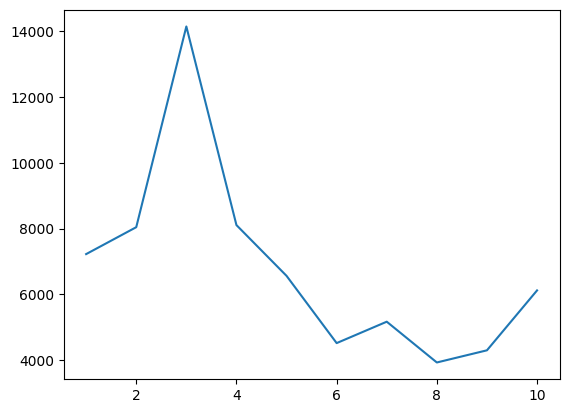

In [34]:
# Graficamos la evolución de la perplejidad con las épocas.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

Aca podemos observar que salvo entre la segunda y tercer época, la perplejidad fue bajando y que en la época 9 ya comenzó a subir nuevamente

In [35]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model2.keras')

Predicción de la próxima palabra utilizando la interfaz de gradio

In [49]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://6355442a564e3e5fc4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://6355442a564e3e5fc4.gradio.live


Generación de secuencias

In [51]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0,-1,:])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text

In [55]:
input_text='she said that'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


'she said that she was not so much'

Beam search y muestreo aleatorio

In [43]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [56]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [74]:
# predicción con beam search utilizando el modo estocastico
salidas = beam_search(model,num_beams=10,num_words=5,input="tomorrow i will",temp=1,mode='sto')

In [75]:
# veamos las salidas
decode(salidas[0])

['i will be so much at some']

In [66]:
# predicción con beam search utilizando el modo deterministico
salidas = beam_search(model,num_beams=10,num_words=5,input="tomorrow i will",temp=1,mode='det')

In [67]:
# veamos las salidas
decode(salidas[0])

['i will be so much of the']

In [77]:
# predicción con beam search modificando la temperatura
salidas = beam_search(model,num_beams=10,num_words=5,input="tomorrow i will",temp=2,mode='sto')
# veamos las salidas
decode(salidas[0])

['i will feel the mr sensible every']

Conclusion:
Cuando intentamos predecir la siguiente palabra funcionó relativamente bien: yo puse "i went" y respondió "i went to".
Cuando intentamos que prediga toda la oración, ahi empezamos a ver que comienza a fallar y generar oraciones que no hacen sentido.